In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'msft' # ticker symbol
train = 0 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1, 3, or 5 days ahead
days_back = -1 # -1 for current data point, -2 for two days ago, etc...
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'a': '11/15/1999' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'aapl':'12/12/1980' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'acy': '01/18/1998' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'adbe': '08/11/1986' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'amat': '03/16/1980' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'amd': '03/17/1980' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'amzn': '05/12/1997' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'baba': '09/15/2014' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'bac': '02/19/1973' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'crm': '06/23/2004' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'fslr': '11/12/2006' # Updated 1/10/21 1D, 3D, 5D ahead 
               , 'goog': '08/16/2004' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'idex': '05/23/2007' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'intc': '03/16/1980' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'iyw': '05/15/2000' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'ma': '05/21/2006' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'mdb': '10/15/2017' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'msft': '03/10/1986' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'mu': '05/28/1984' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'nga': '10/08/2020' # Updated 1/14/21 1D, 3D, 5D ahead
               , 'nio': '09/10/2018' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'nvda': '01/22/1999' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'pypl': '07/05/2015' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'orcl': '03/10/1986' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'qqq': '03/08/1999' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'tsla': '06/29/2010' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'v': '03/16/2008' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'vbiv': '09/04/2002' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'vbr': '01/26/2004' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'viov': '09/06/2010' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'vgt': '01/26/2004' # Updated 1/10/21 1D, 3D, 5D ahead
               , 'xlk': '12/21/1998' # Updated 1/10/21 1D, 3D, 5D ahead
              }

In [4]:
# X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)
# stock_df.tail(10)

In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
# if train == 1:
#     a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
# elif train == 0:
#     pass

In [6]:
# Load RandomForextClassifier Model
# rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

In [7]:
# ROC Curve
# a.roc_plot(y_test, y_probs, stock_name, model_name)

In [8]:
# Precision Recall Curve
# a.prec_recall(y_test, y_probs, stock_name, model_name)

In [9]:
# Confusion Matrix
# a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
# a.cross_validation(rfc_model
#                    , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
#                    , stock_df['direction']
#                    , cv = 5
#                   )

### Prediction...

In [11]:
# Prediction, use last day of data
# stock_df.iloc[-1]

In [12]:
# import numpy as np
# last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-days_back]
# last

In [13]:
# stock_df['adj'].describe()

In [14]:
# if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
#     print(f'Buy {stock_name} {days_ahead} day(s) ahead')
# else:
#     print(f'Sell or hold {stock_name} {days_ahead} day(s) ahead')

### Strategy Returns...

In [15]:
# returns on strategy column
# stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
# stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
# stock_df.tail(5)

In [17]:
# Don't trade every day!
# import matplotlib.pyplot as plt
# test_length = len(y_test)
# (stock_df['returns'][-test_length:] + 1).cumprod().plot()
# plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
# returns_on_ones = []
# for idx in range(-test_length, 0):
#     if stock_df['prediction'][idx] == 1:
#         returns_on_ones.append(1 + stock_df['returns'][idx])

# returns = 1
# for x in returns_on_ones:
#     returns *= x
# returns

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
# test_idx = int(len(stock_df)*0.75)
# (stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/

### Training

In [22]:
# Train all...this takes a while, 12+ hours!
stocks = [x for x in start_dates]
days_ahead = [1, 3, 5]
cv = 5
for stock in stocks:
    for days in days_ahead:
        X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
        a.rfc_GridSearch(X_train, y_train, stock, days, cv)
len(stocks)
#
#
# Train desired stocks...takes less time
# stocks = ['nga']
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)

### Display All Results

Buy vbiv 5 day(s) ahead
Model Returns (x 100 for %): 1.1461
Stock Returns (x 100 for %): -0.832


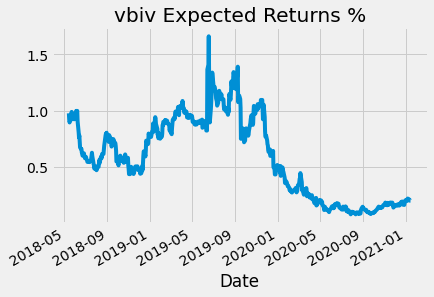

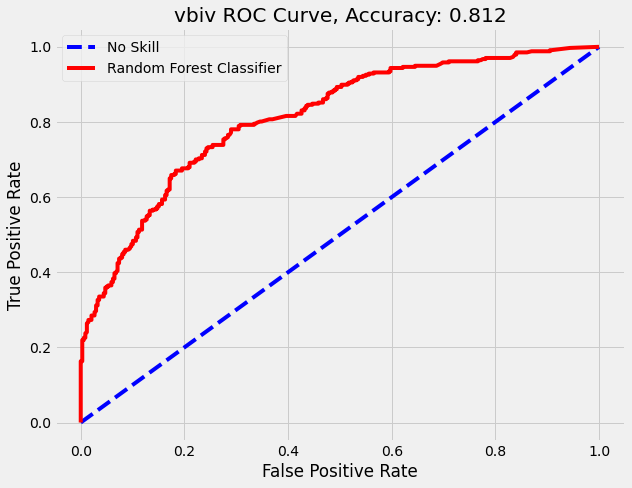

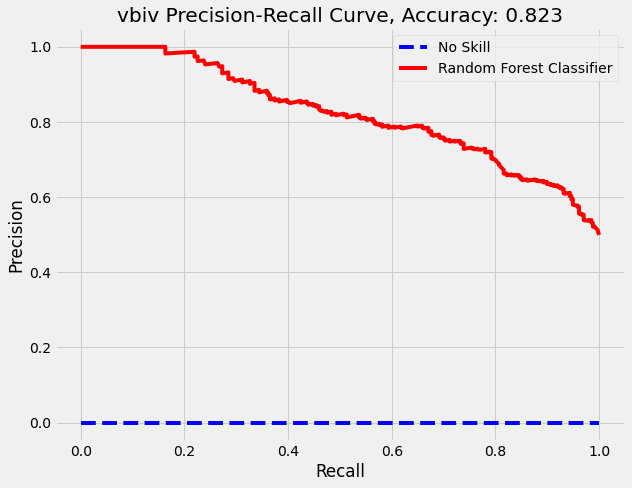

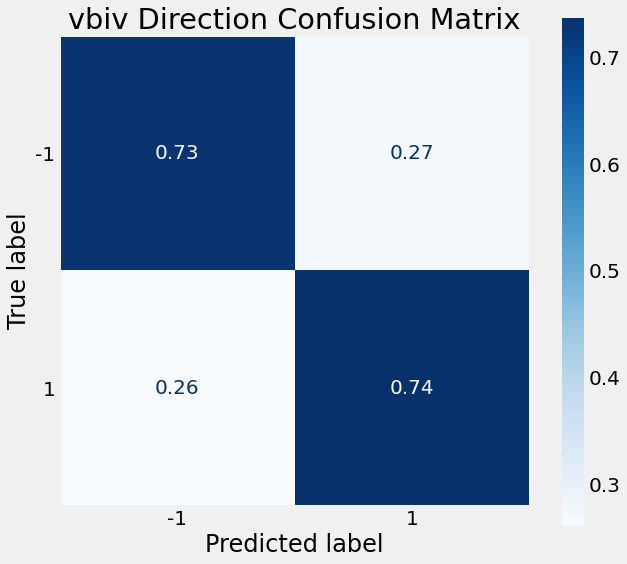

In [23]:
stock_name = 'vbiv'
a.all_func(stock_name
           , start_dates[stock_name]
           , days_ahead = 5
           , model_name = model_name
           , days_back = 1
          )

### Data Frame of Predictions 1 3 5 Days

In [24]:
from datetime import date

today = date.today()
print("Today's date:", today)

Today's date: 2021-01-15


In [25]:
summary_df = a.pred_summary_df(start_dates, stocks = [x for x in start_dates], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,a,Hold or Sell,3.5637,Hold or Sell,3.8725,Buy,4.1383,6.5856
1,aapl,Buy,3.4042,Buy,3.8198,Buy,4.4465,336.0340
2,acy,Buy,0.4556,Buy,0.4515,Buy,0.5776,1.3330
3,adbe,Buy,6.4254,Buy,6.5074,Buy,6.9130,97.3796
4,amat,Buy,5.7473,Buy,5.8569,Buy,6.6750,173.8598
5,amd,Buy,7.3593,Buy,5.9181,Buy,7.4667,15.4112
6,amzn,Buy,3.7932,Buy,4.3037,Buy,4.3463,106.1540
7,baba,Buy,1.2992,Hold or Sell,1.2712,Buy,1.0789,2.0971
8,bac,Buy,4.1336,Buy,4.5647,Buy,6.8998,6.1615
9,crm,Buy,2.1127,Buy,1.9527,Buy,2.1738,12.0202


In [26]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(2.62175, 2.6900500000000003, 2.81195, 7.1681)